In [28]:
# %%
import os
import numpy as np
import torch
import h5py
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from tqdm import tqdm

data_dir = "/beegfs/desy/user/kaechben/calochallenge/"
mode="train"

electron_file = h5py.File(
    data_dir + {"train": "dataset_2_1.hdf5", "test": "dataset_2_2.hdf5"}[mode], "r"
)
energies = electron_file["incident_energies"][:]
showers = electron_file["showers"][:]

outL = [
    shower_to_pc(e)
    for e in tqdm(zip(torch.tensor(showers), torch.tensor(energies)))
]
outD = {k: [e[k] for e in outL] for k in outL[0].keys()}




# %%

# %%

0it [00:00, ?it/s]/tmp/ipykernel_235499/3152804180.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "Egen": torch.tensor(E).squeeze().clone(),
100000it [00:49, 2009.50it/s]


TypeError: only integer scalar arrays can be converted to a scalar index

In [47]:

def shower_to_pc(args):
    shower, E = args
    shower, E = shower.clone(), E.clone()

    shower = shower.reshape(num_z, num_alpha, num_r)
    # assert shower.shape == etas.shape == phis.shape
    idxs = torch.where(shower)
    h_energy = shower[idxs]
    z, alpha, r = idxs
    z=z.float()+torch.rand(z.shape)
    alpha=alpha+torch.rand(alpha.shape)
    r=r+torch.rand(r.shape)
    # hitsperlayer = (shower != 0).float().sum((1, 2))
    # assert (
    #     hitsperlayer[hitsperlayer != 0]
    #     == torch.unique(idxs[0], sorted=True, return_counts=True)[1]
    # ).all()
    # zp = z - num_z / 2
    # theta = torch.arctan(zp / r)
    # eta = torch.log(torch.tan(theta / 2))
    # phi = alpha
    pc = torch.stack([h_energy, z, alpha, r,]).T
    return {
        "Egen": torch.tensor(E).squeeze().clone(),
        "E_z_alpha_r": pc.clone(),
    }


# %%
# creating instance of HighLevelFeatures class to handle geometry based on binning file
class ScalerBase:
    def __init__(self, transfs, featurenames: list[str]) -> None:
        self.transfs = transfs
        self.featurenames = featurenames
        self.n_features = len(self.transfs)

        self.scalerpath = Path(data_dir) / "scaler.gz"
        if self.scalerpath.is_file():
            self.transfs = joblib.load(self.scalerpath)

    def save_scalar(self, pcs: torch.Tensor):
        # The features need to be converted to numpy immediatly
        # otherwise the queuflow afterwards doesnt work
        assert pcs.dim() == 2
        assert self.n_features == pcs.shape[1]
        pcs = pcs.detach().cpu().numpy()
        self.plot_scaling(pcs)

        assert pcs.shape[1] == self.n_features
        pcs = np.hstack(
            [
                transf.fit_transform(arr.reshape(-1, 1))
                for arr, transf in zip(pcs.T, self.transfs)
            ]
        )
        self.plot_scaling(pcs, True)

        joblib.dump(self.transfs, self.scalerpath)

    def transform(self, pcs: np.ndarray):
        assert len(pcs.shape) == 2
        assert pcs.shape[1] == self.n_features
        return np.hstack(
            [
                transf.fit_transform(arr.reshape(-1, 1))
                for arr, transf in zip(pcs.T, self.transfs)
            ]
        )

    def inverse_transform(self, pcs: torch.Tensor):
        assert pcs.shape[-1] == self.n_features
        orgshape = pcs.shape
        dev = pcs.device
        pcs = pcs.to("cpu").detach().reshape(-1, self.n_features).numpy()

        t_stacked = np.hstack(
            [
                transf.inverse_transform(arr.reshape(-1, 1))
                for arr, transf in zip(pcs.T, self.transfs)
            ]
        )
        return torch.from_numpy(t_stacked.reshape(*orgshape)).float().to(dev)

    def plot_scaling(self, pcs, post=False):
        for k, v in zip(self.featurenames, pcs.T):
            fig, ax = plt.subplots(figsize=(10, 7))
            ax.hist(v, bins=500)
            fig.savefig(
                Path(data_dir) / f"{k}_post.png"
                if post
                else Path(data_dir) / f"{k}_pre.png"
            )
            plt.close(fig)


In [48]:

num_z = 9
num_alpha = 16
num_r = 45


mode="train"
if mode == "train":
    scalar = ScalerBase(
        transfs=[
            PowerTransformer(method="box-cox", standardize=True),
            MinMaxScaler(),
            MinMaxScaler(),
            MinMaxScaler(),

        ],
        featurenames=["E", "z", "alpha", "r"],
    )
    arr = torch.vstack(outD["E_z_alpha_r"])[:100]

    scalar.save_scalar(arr)

    for ievent in tqdm(range(len(outD["E_z_alpha_r"]))):
        outD["E_z_alpha_r"][ievent] = torch.tensor(
            scalar.transform(outD["E_z_alpha_r"][ievent].numpy())
        )
    torch.save(outD, f"{data_dir}pc_{mode}.pt")


100%|██████████| 100000/100000 [15:21<00:00, 108.47it/s]


In [19]:
[transf.transform(arr.reshape(-1, 1))             for arr, transf in zip(pcs.T, self.transfs)]

AttributeError: 'list' object has no attribute 'numpy'

In [24]:
arr[:,0].min()



tensor(0.0152, dtype=torch.float64)

(array([16026072., 24158207., 26290447., 24924452., 21597186., 17304647.,
        12665503.,  8313108.,  4885378.,  2628468.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

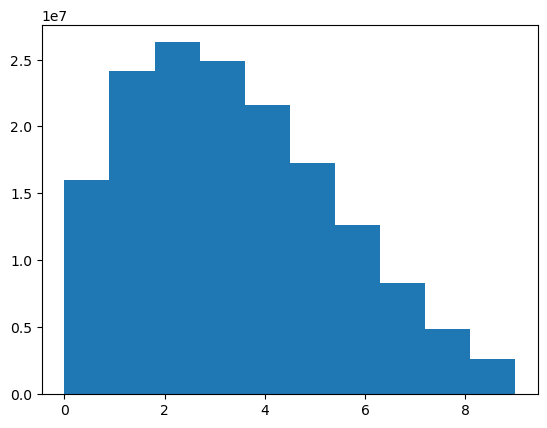

In [26]:
plt.hist(arr[:,1].numpy())